# Assignment 1
## Calculating and Analyzing Vehicle Speed

## What are we looking to accomplish?

Here we will be loading in files available from STIB API that provides timestamped locations of all vehicles on the STIB network. The data is provided in several reference files:
- calendars and bus route data (.txt)
- timestamp locations (.json)
- bus stop and route locations are in shapefiles (.shp)

 > #### The most significant challenge in the data is that there is no unique identifier for each vehicle moving through the system.

The data provided shows what line a bus is on, which direction it is heading (towards or away from the terminus), and which stop it is heading towards. A single snapshot in time provides all this info for every vehicle on the STIB network.

We will need to:
1. Load files in and manipulate them into a convenient working format (e.g. unpack the .json files)
2. Merge columns from different reference tables
3. Find a way to artificially "track" a vehicle along it's route
4. Calculate the vehicle speed using some segment of distance

Let's go!

In [24]:
import datetime
import json
import os
from enum import Enum
from functools import reduce
from itertools import count
from operator import add
import numpy as np

import pandas as pd
import shapefile
from tqdm.notebook import tqdm
from numpy import inf

from scripts.helpers import *

## Convert Raw JSON to CSV

Here we convert the raw JSON files containing vehiclePositions from STIB into a single CSV file. These files were generated by invoking the [Vehicle Position Real-Time API](https://www.stib-mivb.be/irj/go/km/docs/resource/OpenData/9529ab42-f3fc-4960-bf21-703db6d6cc57.pdf) of stib-mivb. Every 30 seconds, the API was called 9 times. Each call was for 10 lines IDs. The time attribute is the time in milliseconds (unix epoch) at which the API was invoked. The response array has the result of the 9 API calls.

The API calls were completed this way due to limitations on the number of lines that can be queried at a time. Multiple JSON files were created for redundancy's sake and for easier transfer between the original pull and project work.

We then iterate through the JSON files and extract the timestamp, lineId, directionId, distanceFromPoint, and pointId. This new CSV file becomes the base data for the remainder of the project.

**Readsfrom**: raw JSON files in `data/raw` folder (`data/raw/vehiclePosition*.json`)
**Writes to**: Single CSV file containing all the vehicle positions in `data` folder (`data/processed/assignment1/vehiclePositions.csv`)

In [14]:
raw_json_files = [
    '../data/raw/vehicleTimestamp/vehiclePosition01.json',
    '../data/raw/vehicleTimestamp/vehiclePosition02.json',
    '../data/raw/vehicleTimestamp/vehiclePosition03.json',
    '../data/raw/vehicleTimestamp/vehiclePosition04.json',
    '../data/raw/vehicleTimestamp/vehiclePosition05.json',
    '../data/raw/vehicleTimestamp/vehiclePosition06.json',
    '../data/raw/vehicleTimestamp/vehiclePosition07.json',
    '../data/raw/vehicleTimestamp/vehiclePosition08.json',
    '../data/raw/vehicleTimestamp/vehiclePosition09.json',
    '../data/raw/vehicleTimestamp/vehiclePosition10.json',
    '../data/raw/vehicleTimestamp/vehiclePosition11.json',
    '../data/raw/vehicleTimestamp/vehiclePosition12.json',
    '../data/raw/vehicleTimestamp/vehiclePosition13.json'
]
vehicle_positions_csv = '../data/processed/assignment1/vehiclePositions.csv'
csv_header = ['Timestamp', 'LineId', 'DirectionId', 'DistanceFromPoint', 'PointId']

In [15]:
with write_csv(vehicle_positions_csv) as writer:
    writer.writerow(csv_header)
    for raw_json_path in tqdm(raw_json_files):
        file = open(raw_json_path, 'r', encoding='utf8')
        data = json.load(file)['data']
        file.close()
        for time in data:
            timestamp = time['time']
            for response in time['Responses']:
                if response is None:
                    # Skip if response is empty
                    continue
                for line in response['lines']:
                    line_id = line['lineId']
                    for vehiclePosition in line['vehiclePositions']:
                        writer.writerow([
                            timestamp,
                            line_id,
                            vehiclePosition['directionId'],
                            vehiclePosition['distanceFromPoint'],
                            vehiclePosition['pointId'],
                        ])

  0%|          | 0/13 [00:00<?, ?it/s]

In [16]:
vehicle_positions_df = pd.read_csv(vehicle_positions_csv)
vehicle_positions_df.head()

,Timestamp,LineId,DirectionId,DistanceFromPoint,PointId
0,1630914886924,1,8161,1,8012
1,1630914886924,1,8162,0,8142
2,1630914886924,1,8162,0,8282
3,1630914886924,1,8731,0,8111
4,1630914886924,1,8162,1,8062


## Shapefile to routes

Now we will transform the shapefiles by converting the raw stops Shapefiles from STIB to a single CSV file containing line routes. The ACTU_STOPS file provides information on the order in which a vehicle makes its stops. We will also merge the ACTU_STOPS shapefile with the stops.txt file to have access to GPS coordinates in 2 formats:
 - Belgian Lambert 1972 (EPSG 31370)
 - World Geodectic System 29814 (ESPG 4326)

This will be useful later on when calculating distances, as we can use euclidean distance calculations when dealing with Belgium Lambert 1972 projections.

**Reads from**:
 - Shapefiles in `data/raw/shapefiles` folder (`data/raw/shapefiles/ACTU_STOPS.*`)
 - `stops.txt` GTFS file in `data/raw/gtfs` folder

**Writes to**: Single CSV file containing all the line routes in `data` folder (`data/line_stops.csv`)

In [13]:
csv_header = ['lineId', 'direction', 'stop_id', 'stop_id_int', 'name', 'name_ascii', 'lat', 'long', 'lambert_x',
              'lambert_y', 'order']
stops_shapefile_path = '../data/raw/shapefiles/ACTU_STOPS.shp'
stops_gtfs_path = '../data/raw/gtfs/stops.csv'
merged_stops_csv_path = '../data/processed/assignment1/line_stops.csv'

In [14]:
stops_shapefile = shapefile.Reader(stops_shapefile_path)
# We take the first value of each field tuple (its name), and skip the first field (DeletionFlag field, not relevant)
stop_fields = [field[0] for field in stops_shapefile.fields][1:]
shapefile_df = pd.DataFrame(stops_shapefile.records(), columns=stop_fields)
shapefile_df.head()

,Code_Ligne,Variante,succession,stop_id,descr_fr,descr_nl,alpha_fr,alpha_nl,coord_x,coord_y,mode,numero_lig,terminus
0,012b,1,1,9600B,BRUSSELS AIRPORT,BRUSSELS AIRPORT,Brussels Airport,Brussels Airport,157950.0,176429.0,B,12,BRUSSELS CITY
1,012b,1,2,3017,BOURGET,BOURGET,Bourget,Bourget,154334.0,174200.0,B,12,BRUSSELS CITY
2,012b,1,3,5048,DA VINCI,DA VINCI,Da Vinci,Da Vinci,152934.0,173976.0,B,12,BRUSSELS CITY
3,012b,1,4,2695,GENEVE,GENEVE,Genève,Genève,152428.0,172606.0,B,12,BRUSSELS CITY
4,012b,1,5,2250,MEISER,MEISER,Meiser,Meiser,152045.0,171508.0,B,12,BRUSSELS CITY


In [15]:
shapefile_df.drop(columns=['descr_nl', 'alpha_nl', 'mode', 'numero_lig', 'terminus'], inplace=True)
renames = {'Code_Ligne': 'lineId',
           'Variante': 'direction',
           'succession': 'order',
           'descr_fr': 'name_ascii',
           'alpha_fr': 'name',
           'coord_x': 'lambert_x',
           'coord_y': 'lambert_y'}
shapefile_df.rename(columns=renames, inplace=True)
shapefile_df.sort_values(['lineId', 'direction', 'order'], inplace=True)
shapefile_df['stop_id_int'] = shapefile_df['stop_id'].apply(lambda stop_id: int(stop_id[:4]))
shapefile_df.head()

,lineId,direction,order,stop_id,name_ascii,name,lambert_x,lambert_y,stop_id_int
2987,001m,1,1,8733,GARE DE L'OUEST,Gare de l'Ouest,146633.5,170956.4,8733
2988,001m,1,2,8742,BEEKKANT,Beekkant,146776.5,171444.3,8742
2989,001m,1,3,8292,ETANGS NOIRS,Étangs Noirs,147492.7,171859.9,8292
2990,001m,1,4,8282,COMTE DE FLANDRE,Comte de Flandre,148013.6,171590.4,8282
2991,001m,1,5,8272,SAINTE-CATHERINE,Sainte-Catherine,148539.5,171278.2,8272


In [16]:
gtfs_stops_df = pd.read_csv(stops_gtfs_path)
gtfs_stops_df.dropna(axis=1, inplace=True)
gtfs_stops_df['stop_id_int'] = gtfs_stops_df['stop_id'].apply(lambda stop_id: int(stop_id[:4]))
gtfs_stops_df.drop(columns=['stop_id', 'location_type', 'stop_name'], inplace=True)
gtfs_stops_df.set_index('stop_id_int', inplace=True)
gtfs_stops_df.head()

,stop_lat,stop_lon
stop_id_int,,
89,50.838006,4.408970
470,50.863666,4.329612
471,50.863732,4.329236
472,50.863543,4.329023
473,50.863418,4.330031


In [17]:
joined_stops_df = shapefile_df.join(gtfs_stops_df, on='stop_id_int')
joined_stops_df.head()

,lineId,direction,order,stop_id,name_ascii,name,lambert_x,lambert_y,stop_id_int,stop_lat,stop_lon
2987,001m,1,1,8733,GARE DE L'OUEST,Gare de l'Ouest,146633.5,170956.4,8733,50.848999,4.320948
2988,001m,1,2,8742,BEEKKANT,Beekkant,146776.5,171444.3,8742,50.853386,4.322974
2989,001m,1,3,8292,ETANGS NOIRS,Étangs Noirs,147492.7,171859.9,8292,50.857125,4.333143
2990,001m,1,4,8282,COMTE DE FLANDRE,Comte de Flandre,148013.6,171590.4,8282,50.854705,4.340542
2991,001m,1,5,8272,SAINTE-CATHERINE,Sainte-Catherine,148539.5,171278.2,8272,50.851900,4.348012


In [18]:
joined_stops_df[joined_stops_df['stop_lat'].isna()]

,lineId,direction,order,stop_id,name_ascii,name,lambert_x,lambert_y,stop_id_int,stop_lat,stop_lon
3424,019t,1,1,5104F,GROOT-BIJGAARDEN,Groot-Bijgaarden,143429.4,172979.7,5104,NaN,NaN
3467,019t,2,22,5169F,GROOT-BIJGAARDEN,Groot-Bijgaarden,143385.5,172978.7,5169,NaN,NaN


In [19]:
file = open(merged_stops_csv_path, 'w', encoding='utf8')
joined_stops_df.to_csv(file, index=False)
file.close()

## Drop incomplete data from CSV

Now we will clean the `vehiclePositions.csv` file created in previous section by comparing each datapoint to see if the stopId exists in the recently created `merged_stops.csv`. When we checked that file, there was only one undefined stop based on GPS position, so we are treating the GTFS file provided by STIB as being the most accurate source of truth.

When we check the stopIds that exist in `vehiclePositions.csv` against the `merged_stops.csv`, we will see that we lost 11.7% (~2.3M timestamps out of 19.4M) of our data. This first data drop is assumed to be due to the "technical stops" described in the STIB documentation that are not true passenger stops and can be ignored. The number of timestamps dropped is different for each line, and the percentage drop is shown.

Depending on the business case, it would be worthwhile evaluating data line by if a granular data analysis is required. For the purposes of this project, we are looking at the STIB network performance as a whole and did not dive further into the data drops.

**Reads from**: CSV file containing all the vehicle positions in `data` folder (`data/processed/assignment1/vehiclePositions.csv`)
**Writes to**: CSV file containing filtered vehicle positions in `data` folder (`data/processed/assignment1/vehiclePositionsClean.csv`)

In [20]:
stops_csv_path = '../data/processed/assignment1/line_stops.csv'
positions_csv_path = '../data/processed/assignment1/vehiclePositions.csv'
cleaned_positions_csv_path = '../data/processed/assignment1/vehiclePositionsClean.csv'

In [21]:
stops_df = pd.read_csv(stops_csv_path)
stop_ids = stops_df['stop_id_int']
stops_df.head()

,lineId,direction,order,stop_id,name_ascii,name,lambert_x,lambert_y,stop_id_int,stop_lat,stop_lon
0,001m,1,1,8733,GARE DE L'OUEST,Gare de l'Ouest,146633.5,170956.4,8733,50.848999,4.320948
1,001m,1,2,8742,BEEKKANT,Beekkant,146776.5,171444.3,8742,50.853386,4.322974
2,001m,1,3,8292,ETANGS NOIRS,Étangs Noirs,147492.7,171859.9,8292,50.857125,4.333143
3,001m,1,4,8282,COMTE DE FLANDRE,Comte de Flandre,148013.6,171590.4,8282,50.854705,4.340542
4,001m,1,5,8272,SAINTE-CATHERINE,Sainte-Catherine,148539.5,171278.2,8272,50.851900,4.348012


In [37]:
positions_df = pd.read_csv(positions_csv_path)
positions_df.count()

Timestamp            19421883
LineId               19421883
DirectionId          19421883
DistanceFromPoint    19421883
PointId              19421883
dtype: int64

In [23]:
cleaned_positions_df = positions_df[positions_df['DirectionId'].isin(stop_ids) & positions_df['PointId'].isin(stop_ids)]
cleaned_positions_df.count()

Timestamp            17153015
LineId               17153015
DirectionId          17153015
DistanceFromPoint    17153015
PointId              17153015
dtype: int64

In [26]:
original_counts = positions_df['LineId'].value_counts()
new_counts = cleaned_positions_df['LineId'].value_counts()
counts_df = original_counts.to_frame('original_counts').join(new_counts.to_frame('new_counts'))
counts_df.head()

,original_counts,new_counts
95,531447,240516
7,529144,526086
82,515924,506619
81,504996,256610
51,500110,483565


    original_counts  new_counts  positions_dropped  percentage_dropped
1            305454      246596              58858           19.269023
2            215114      214341                773            0.359344
3            383543      373963               9580            2.497764
4            282947      281293               1654            0.584562
5            405897      405853                 44            0.010840
..              ...         ...                ...                 ...
92           486408      475895              10513            2.161354
93           402974      223230             179744           44.604367
95           531447      240516             290931           54.743182
97           276705      276501                204            0.073725
98            98755       98755                  0            0.000000

[74 rows x 4 columns]


<AxesSubplot:title={'center':'Percentage of Timestamps Dropped by Line'}>

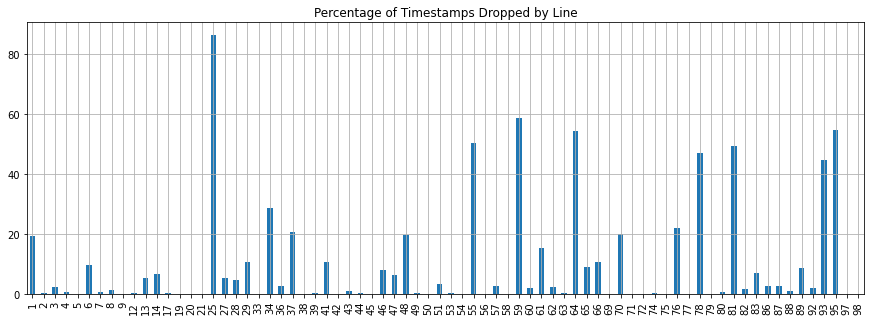

In [31]:
counts_df['positions_dropped'] = counts_df['original_counts'] - counts_df['new_counts']
counts_df['percentage_dropped'] = counts_df['positions_dropped'] * 100 / counts_df['original_counts']
counts_df.sort_index(inplace=True)
print(counts_df)
counts_df['percentage_dropped'].plot(kind='bar', figsize=(15,5), grid=True, title="Percentage of Timestamps Dropped by Line")

In [22]:
cleaned_positions_df.to_csv(cleaned_positions_csv_path, index=False)

## Add direction to CSV

Here we add the direction that a vehicle is moving to `vehiclePositionsClean.csv` that was just created based on some information in the stops. For the majority of vehicle trips, the stop id on one side of the road is different from that on the other side of the road.

> **Example:** There will be 2 different IDs for stop "Thys" on bus route 95. One will be associated with a direction going towards city center, and one is associated with a direction going out of city center.

It could also be the case that the stop is the last stop of a direction, in this case, the direction is set depending on which line the stop is in.

For the 2 complex cases, a comparison is completed between the stop_id and destination_id and the direction is set depending on which of the two comes first in the route sequence.

**Reads from**: CSV file containing filtered vehicle positions in `data` folder (`data/processed/assignment1/vehiclePositionsClean.csv`)
**Writes to**: CSV file containing filtered vehicle positions with direction in `data` folder (`data/processed/assignment1/vehiclePositionsCleanDirected.csv`)

In [86]:
def get_direction_from_line_stop_and_destination(line: Tuple[List[List[str]], List[List[str]]], stop_id: str,
                                                 destination_id: str) -> int:
    # Simple case 1 -> destination_id is in one direction but not in the other:
    stops = ({stop[3] for stop in line[0]}, {stop[3] for stop in line[1]})
    if destination_id in stops[0] and destination_id not in stops[1]:
        return 0
    if destination_id not in stops[0] and destination_id in stops[1]:
        return 1

    # Simple case 2 -> destination_id is the last stop of a direction:
    if destination_id == line[0][-1][3]:
        return 0
    if destination_id == line[1][-1][3]:
        return 1

    # Simple case 3 -> stop_id is in one direction but not in the other:
    if stop_id in stops[0] and stop_id not in stops[1]:
        return 0
    if stop_id not in stops[0] and stop_id in stops[1]:
        return 1

    # Complex case 1 -> if stop_id != destination_id, return the direction in which the stop with
    # id destination_id is after the stop with id stop_id
    if stop_id != destination_id:
        index_of_destination_0 = next(int(stop[8]) for stop in line[0] if stop[3] == destination_id)
        index_of_stop_0 = next(int(stop[8]) for stop in line[0] if stop[3] == stop_id)
        return 0 if index_of_stop_0 < index_of_destination_0 else 1
    # Complex case 2 -> if stop_id == destination_id, return the direction in which the stop with
    # id destination_id is further down the direction
    else:
        index_of_destination_0 = next(int(stop[8]) for stop in line[0] if stop[3] == destination_id)
        index_of_destination_1 = next(int(stop[8]) for stop in line[1] if stop[3] == destination_id)
        return 0 if index_of_destination_0 > index_of_destination_1 else 1

In [87]:
def add_direction_to_csv():
    positions = read_csv_stream('../data/processed/assignment1/vehiclePositionsClean.csv', skip_first=False)
    directed_positions, output_file = get_csv_writer('../data/processed/assignment1/vehiclePositionsCleanDirected.csv')
    directed_positions.writerow([*next(positions), 'Direction'])
    grouped_lines = group_line_stops(read_csv_stream('../data/processed/assignment1/line_stops.csv'))
    memory = {}
    for position in tqdm(positions):
        line_id = position[1]
        stop_id = position[4]
        destination_id = position[2]
        tuple_id = f'{line_id}-{stop_id}-{destination_id}'
        if tuple_id not in memory:
            memory[tuple_id] = get_direction_from_line_stop_and_destination(grouped_lines[line_id], stop_id,
                                                                            destination_id)
        directed_positions.writerow([*position, memory[tuple_id]])
    output_file.close()

In [88]:
add_direction_to_csv()

0it [00:00, ?it/s]

## Split CSV into lines

For future manipulation, especially during the SARIMA time-series prediction modelling for arrival time at a stop, we will split the data in `vehiclePositionsCleanDirected.csv` into individual csv files based on each line. Given the size of the data set, this will also help in doing some exploratory testing on smaller subsets of data to ensure the approach being implemented makes sense.

**Reads from**: CSV file containing filtered vehicle positions with direction in `data` folder (`data/processed/assignment1/vehiclePositionsCleanDirected.csv`)
**Writes to**: CSV file per line containing filtered vehicle positions with direction in `data/processed/assignment1/vehiclePositionsPerLine` folder (`data/processed/assignment1/vehiclePositionsPerLine/vehiclePositions*.csv`)

In [89]:
def split_csv_by_lines():
    files = {}
    positions = read_csv_stream('../data/processed/assignment1/vehiclePositionsCleanDirected.csv', skip_first=False)
    output_dir = '../data/processed/assignment1/vehiclePositionsPerLine'
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    header = next(positions)
    for line in tqdm(positions):
        line_id = line[1]
        if line_id not in files:
            files[line_id] = get_csv_writer(
                f'{output_dir}/vehiclePositions{line_id}.csv')
            files[line_id][0].writerow(header)
        files[line_id][0].writerow(line)
    for _, file in files.values():
        file.close()

In [90]:
split_csv_by_lines()

0it [00:00, ?it/s]

## Vehicle Matching

Now we have all the data needed to attempt to link several vehicle positions belonging to same physical vehicle. The general idea is that we will look at every vehicle position at a single timestamp, and compare that to every vehicle at the next timestamp. There are different changes that might have taken place with the stop and distance to stop columns, which will be used to match buses up. So we will:
1. Group positions by timestamp and sort groups
2. Iterate over groups finding matches
3. Match buses depending on stop and distance to stop

This approach means that anytime a vehicle approaches a technical stop (that was previously dropped when we matched our vehiclePosition dataset with the GTFS stopIDs data) we will "lose" that unique bus, and "gain" a new unique bus on the other side of the technical stop. This also means that a bus is "lost" whenever it finishes a sequence at a line terminus and a new bus is "gained" whenever it starts a route at the first stop in a sequence.

For the purpose of calculating distance between stops, this approach works well, as we do not need to know exactly which bus is where, just how long it takes to travel between stops.

> ### The project looks at times and delays from the perspective of a public transport client, who does not care which unique bus arrives at which time, just that ANY bus arrives at the scheduled time

**Reads from**: CSV file per line containing filtered vehicle positions with direction in `data/processed/assignment1/vehiclePositionsPerLine` folder (`data/processed/assignment1/vehiclePositionsPerLine/vehiclePositions*.csv`)
**Writes to**: CSV file per line containing vehicle positions with `bus_id` in `data/processed/assignment1/csv_lines_linked` folder (`data/processed/assignment1/csv_lines_linked/vehiclePositions*.csv`)

In [91]:
def split_positions_by_direction(positions: Iterable[List[str]]) -> Tuple[List[List[str]], List[List[str]]]:
    line = ([], [])
    for position in positions:
        line[int(position[-1])].append(position)
    return line

In [103]:
def get_index_of_stop_in_line(line, direction, stop_id):
    return get_index_of_stop_in_line_direction(line[direction], stop_id)


def get_index_of_stop_in_line_direction(line, stop_id):
    return next((int(stop[-1]) for stop in line if stop[3] == stop_id), -1)


class Match(Enum):
    WRONG = 1
    OK = 2
    TOO_FAR = 3

In [100]:
def group_positions_by_timestamp(positions: Iterable[List[str]]) -> List[Tuple[int, List[List[str]]]]:
    grouped_positions = []
    old_timestamp = -1
    current_timestamp_positions = []
    for position in positions:
        current_timestamp = int(position[0])
        if current_timestamp != old_timestamp:
            assert current_timestamp > old_timestamp
            grouped_positions.append((old_timestamp, current_timestamp_positions))
            old_timestamp = current_timestamp
            current_timestamp_positions = []
        current_timestamp_positions.append(position)
    grouped_positions.append((old_timestamp, current_timestamp_positions))
    return grouped_positions[1:]

In [101]:
def possible_match(first_position: List[str], second_position: List[str],
                   line: List[List[str]]) -> Match:
    first_stop_id = first_position[4]
    second_stop_id = second_position[4]
    # Both positions are in the same stop -> Compare using distance from that stop
    if first_stop_id == second_stop_id:
        first_distance = int(first_position[3])
        second_distance = int(second_position[3])
        return Match.OK if first_distance <= second_distance else Match.WRONG
    # Positions are in different stops -> Compare using order of stops in direction
    else:
        # Assert both positions have the same direction
        first_stop_index = get_index_of_stop_in_line_direction(line, first_stop_id)
        second_stop_index = get_index_of_stop_in_line_direction(line, second_stop_id)
        if second_stop_index - first_stop_index > 3:
            return Match.TOO_FAR
        return Match.OK if first_stop_index < second_stop_index else Match.WRONG

In [102]:
def find_bus_matched_of_line_direction(positions: Iterable[List[str]], line: List[List[str]], line_id: str,
                                       direction: int, writer):
    grouped_positions = group_positions_by_timestamp(positions)
    previous_positions = []
    bus_id = (f'{line_id}-{direction}-{i:06d}' for i in count())
    sorting_key = lambda vehicle_position: get_index_of_stop_in_line_direction(line, vehicle_position[-2])

    for timestamp, current_positions in grouped_positions:
        sorted_positions = sorted(current_positions, key=sorting_key)
        while len(sorted_positions) > 0 and get_index_of_stop_in_line_direction(line, sorted_positions[0][-2]) == -1:
            sorted_positions.pop(0)
        current_previous_position_index = 0
        current_position_index = 0
        while current_position_index < len(sorted_positions) and current_previous_position_index < len(
                previous_positions):
            previous_position = previous_positions[current_previous_position_index]
            current_position = sorted_positions[current_position_index]
            result = possible_match(previous_position, current_position, line)
            if result == Match.OK:
                current_position.append(previous_position[-1])
                current_previous_position_index += 1
                current_position_index += 1
            elif result == Match.WRONG:
                current_position.append(next(bus_id))
                current_position_index += 1
            elif result == Match.TOO_FAR:
                current_previous_position_index += 1
        for position in sorted_positions:
            if len(position) == 6:
                position.append(next(bus_id))
            writer.writerow(position)
        previous_positions = sorted_positions

In [96]:
def find_bus_matches_of_line(file_path: str, output_path: str, line_id: str,
                             line: Tuple[List[List[str]], List[List[str]]]) -> None:
    positions = read_csv_stream(file_path, skip_first=False)
    with write_csv(output_path) as linked_positions:
        linked_positions.writerow([*next(positions), 'BusId'])
        direction1, direction2 = split_positions_by_direction(positions)
        find_bus_matched_of_line_direction(direction1, line[0], line_id, 0, linked_positions)
        find_bus_matched_of_line_direction(direction2, line[1], line_id, 1, linked_positions)


In [97]:
def find_bus_matches_of_lines():
    path = '../data/processed/assignment1/vehiclePositionsPerLine'
    output_path = '../data/processed/assignment1/csv_lines_linked'
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    lines = group_line_stops(read_csv_stream('../data/processed/assignment1/line_stops.csv'))
    for file in tqdm(os.listdir(path)):
        line_id = file[16:-4]
        line = lines[line_id]
        find_bus_matches_of_line(f'{path}/{file}', f'{output_path}/{file}', line_id, line)

In [104]:
find_bus_matches_of_lines()

  0%|          | 0/74 [00:00<?, ?it/s]

# Calculate average time between stops

## Pulling it all together
We now have all the building blocks we need to calculate the time between each stop. Here we will calculate the time between each stop for each line and then create and average of the times at 1hr intervals. Given the focus of the project for an analysis of the STIB network speed, this provides a "low-resolution" version of the data that can be used to draw some powerful initial conclusions with a more compact data set.

After initial analysis and conclusions are drawn, it is possible to come back and generate more granular data at smaller time intervals, look at specific lines with a very high data resolution, or even use a clustering method to develop a dynamic time averaging depending on when the most change in travel time between stops is detected.

For the current revision of the project, no additional granularity of data was used beyond the 1-hour intervals.

In [105]:
def group_positions_by_vehicle(positions: List[List[str]]) -> Dict[str, List[List[List[str]]]]:
    grouped_positions = {}
    for position in positions:
        bus_id = position[-1]
        if bus_id not in grouped_positions:
            grouped_positions[bus_id] = []
        grouped_positions[bus_id].append(position)
    return grouped_positions

In [106]:
def get_hour_from_timestamp(timestamp: int) -> int:
    return datetime.datetime.fromtimestamp(timestamp // 1000).hour

In [107]:
def get_vehicle_times_between_stops(vehicle_positions: List[List[str]],
                                    line: Tuple[List[List[str]], List[List[str]]]) -> List:
    times = []
    previous_timestamp = int(vehicle_positions[0][0])
    previous_stop = vehicle_positions[0][4]
    for position in vehicle_positions:
        current_timestamp = int(position[0])
        current_stop = position[4]
        if current_stop != previous_stop:
            time_difference = (current_timestamp - previous_timestamp) // 1000
            first_hour = get_hour_from_timestamp(previous_timestamp)
            last_hour = get_hour_from_timestamp(current_timestamp)
            times.append([first_hour, previous_stop, current_stop, time_difference])
            if first_hour != last_hour:
                times.append([last_hour, previous_stop, current_stop, time_difference])
            previous_stop = current_stop
            previous_timestamp = current_timestamp
    return times

In [108]:
def calculate_average_time_between_stops_of_line(positions: List[List[str]], line_id: str,
                                                 line: Tuple[List[List[str]], List[List[str]]], output):
    grouped_positions = group_positions_by_vehicle(positions)
    times = []
    for vehicle_id, vehicle_positions in grouped_positions.items():
        times += get_vehicle_times_between_stops(vehicle_positions, line)
    for direction in [0, 1]:
        for fromStop, toStop in zip(line[direction][:-1], line[direction][1:]):
            time_sum = [0 for _ in range(24)]
            time_sum_filtered = [0 for _ in range(24)]
            time_count = [0 for _ in range(24)]
            time_count_filtered = [0 for _ in range(24)]
            for time in times:
                if time[1] == fromStop[3] and time[2] == toStop[3]:
                    time_sum[time[0]] += time[3]
                    time_count[time[0]] += 1
                    if time[3] < 6000:  # Times larger than 10 minutes are likely anomalies that shouldn't be counted
                        time_sum_filtered[time[0]] += time[3]
                        time_count_filtered[time[0]] += 1
            output[0].writerow(
                [line_id, fromStop[3], toStop[3],
                 *[f'{total / amount:.2f}' if amount > 0 else 0 for total, amount in zip(time_sum, time_count)]])
            output[1].writerow([line_id, fromStop[3], toStop[3], *time_count])
            output[2].writerow(
                [line_id, fromStop[3], toStop[3], *[f'{total / amount:.2f}' if amount > 0 else 0 for total, amount in
                                                    zip(time_sum_filtered, time_count_filtered)]])
            output[3].writerow([line_id, fromStop[3], toStop[3], *time_count_filtered])

In [109]:
def calculate_average_time_between_stops():
    source_path = '../data/processed/assignment1/csv_lines_linked'
    output_path = '../data/processed/assignment1/average_time_between_stops.csv'
    output_path_filtered = '../data/processed/assignment1/average_time_between_stops_filtered.csv'
    output_path_count = '../data/processed/assignment1/average_time_between_stops_count.csv'
    output_path_filtered_count = '../data/processed/assignment1/average_time_between_stops_filtered_count.csv'
    lines = group_line_stops(read_csv_stream('../data/processed/assignment1/line_stops.csv'))
    with write_csv(output_path) as output, write_csv(output_path_filtered) as output_filtered, write_csv(
            output_path_count) as output_count, write_csv(output_path_filtered_count) as output_filtered_count:
        header = ['LineId', 'FromStop', 'ToStop', *[f'{i}' for i in range(24)], 'Day']
        output.writerow(header)
        output_filtered.writerow(header)
        output_count.writerow(header)
        output_filtered_count.writerow(header)
        for file in tqdm(os.listdir(source_path)):
            line_id = file[16:-4]
            line = lines[line_id]
            positions = read_csv_list(f'{source_path}/{file}')[1:]
            calculate_average_time_between_stops_of_line(positions, line_id, line,
                                                         (output, output_count, output_filtered, output_filtered_count))

In [110]:
calculate_average_time_between_stops()

  0%|          | 0/74 [00:00<?, ?it/s]

In [111]:
def calculate_daily_average_time_between_stops():
    source_path = '../data/processed/assignment1/csv_lines_linked'
    output_path = '../data/processed/assignment1/daily_average_time_between_stops_filtered'
    lines = group_line_stops(read_csv_stream('../data/processed/assignment1/line_stops.csv'))
    header = ['LineId', 'FromStop', 'ToStop', *[f'{i}' for i in range(24)]]

    class Dummy:
        def writerow(self, *args):
            pass

    dummy = Dummy()
    day_files = {}
    for file in tqdm(os.listdir(source_path)):
        line_id = file[16:-4]
        line = lines[line_id]
        positions = read_csv_list(f'{source_path}/{file}')[1:]
        day_positions = {}
        for position in positions:
            day = datetime.datetime.fromtimestamp(int(position[0]) / 1000).date().strftime('%Y-%m-%d')
            if day not in day_positions:
                day_positions[day] = []
            day_positions[day].append(position)
        for day in day_positions:
            if day not in day_files:
                day_files[day] = get_csv_writer(f'{output_path}/{day}.csv')
                day_files[day][0].writerow(header)
            calculate_average_time_between_stops_of_line(day_positions[day], line_id, line,
                                                         (dummy, dummy, day_files[day][0], dummy))
    for writer, file in day_files.values():
        file.close()

In [113]:
calculate_daily_average_time_between_stops()

  0%|          | 0/74 [00:00<?, ?it/s]

## Calculating Speed Between Stops

Now that we have the time between stops, the next step to calculate the speed between stops will be to find the distance. To do this, we will iterate through the ACTU_LINES shapefile to find the nearest geometry points to each stop. We will then iterate through the shapefile to calculate the full distance from stop to stop. Once we have distance, we can merge distance and time to find Velocity = distance/time.

We will also prep some data for visualization by creating a GeoJSON array that can be passed into Kepler.gl to plot each individual line segment (stop-to-stop polyline).

**Input Files:**
- line_stops.csv
- ACTU_LINES.shp
- shapes_lat_long.csv
- average_time_between_stops_filtered.csv

**Export Files:**
- stop_distance.csv
- vehicle_speed.csv

In [8]:
line_stops = pd.read_csv('../data/processed/assignment1/line_stops.csv')
sf_actu_lines = shapefile.Reader('../data/raw/shapefiles/ACTU_LINES.shp')
# here we initialize shape_records, which includes a combination of the shapes and records from the shapefile. This combination will allow us to pull the lambert coordinates from the shapes as while also accessing the record information like line_id.
shape_records = sf_actu_lines.shapeRecords()

# Shapefile Distance Calculation Function

Now that we have our libraries loaded and files imported, we will create a function that can calculate the distance between two points on a polyline. The start_point and end_point are indexes to tell us where we should start and stop calculating distance in the polyline. the line_segment is one of the shape elements that will be pulled from the shapefile. This calculation will be called later in an iterative for loop for each shape element withing shape_records.shape.

We will calculate the distance between each point in the shapefile using Pythagoreas' theorem, since the units in both line_stops and the shapefile are already provided in Belgium Lambert 1972 format, which projects the points onto a flat surface.

In [9]:
def calculate_distance_between_polyline_points(start_point: int, stop_point: int,
                                               line_segment: shapefile.Shape) -> float:
    # initializing our total distance to 0
    total_distance = 0
    # we'll need to calculate the distance between each consecutive pair of coordinates, and will iterate
    # from the start_point to the end_point. Each newly caluclated distance between points will be added
    # to the sum total_distance and then returned.
    for index in range(start_point, stop_point - 1):
        current = index
        next = index + 1
        total_distance += sqrt(pow((line_segment.points[current][0] - line_segment.points[next][0]), 2) + pow(
            (line_segment.points[current][1] - line_segment.points[next][1]), 2))
    return total_distance


# Calculate Distance Between Stops

Time to get to work! Here we several nested for loops that are used to compare match up the line in the shapefile to the line in the line_stops. For each matching line, we will cycle through to project the stop location ONTO the polyline. This is required because a bus stop can be imagined to be on a sidewalk, while the polyline is moving along the road.

Once we have matched up our bus stop with the nearest polyline point, we move to the next stop and do the same. Having 2 stop locations projected, we can call the previously defined calculate_distance_between_polyline_points function to find the distance between these 2 stops.

The first iteration of the loop will result in a dummy value, as it does not have a real stop to pair with. All of these dummy values are dropped once the dictionary that stores all values is transformed into a dataframe.

The data frame will be accessed latter with the unique combination of [LineID + fromStopID + toStopID]. This combination will be different depending on which direction a vehicle is moving, as the stop id's are not the same on each side of a street.

We will also hold onto the index value for the polyline location in case we need it later on for future predictions.

**integration**: This is how things were integerated
parameters: Here we dropped all stops before 4am because...

In [10]:
# initialize a dictionary that will be used to make a dataframe and csv file with the following format:
# |    LineId    |   FromStop  |   ToStop  |   distance    |    fromIndex   |    toIndex   |
stop_distance = {'LineId': [], 'LineIdFormatted': [], 'LineId_GeoMerge': [], 'Type': [], 'Direction': [],
                 'FromStop': [], 'ToStop': [], 'distance': [], 'fromIndex': [], 'toIndex': [],
                 'FromStop_lat': [], 'FromStop_lon': [], 'ToStop_lat': [], 'ToStop_lon': []}

# Initializing variables that will be used in loops
last_pointID = 0
last_stop_id = 0
last_stop_lat = 0
last_stop_lon = 0
adjusted_stop_lat_GPS = 0
adjusted_stop_lon_GPS = 0

# look through each shape/record combo in the shape_records file. Each element of shape_records represents a single line (metro, bus or tram)
for shape_record in shape_records:
    record = shape_record.record
    shape = shape_record.shape
    # look through each of the stops that exist in the line_stops csv. Here we are going to only cycle through a subset of the line_stops where there is a match on LineId and the direction to reduce computation time.
    for index, stop in line_stops[
        (line_stops['lineId'] == record['LIGNE']) & (line_stops['direction'] == record['VARIANTE'])].sort_values(
        by=['order']).iterrows():
        # Initializing variables that will be used in loops
        min_distance = 50
        adjusted_stop_lat = 50
        adjusted_stop_lon = 50
        current_pointID = 0
        current_stop_id = stop['stop_id_int']
        stop_lat = stop['lambert_x']
        stop_lon = stop['lambert_y']
        #After choosing a single stop from the line_stops file, we will compare that stops lambert GPS position to each coordinate that makes up the polyline in the current shape_records shape. We are finding the closest location in the shape file to our bus stop location. This can be done using euclidean distance calculation because the coordinates are in lambert notation. Whichever location on the polyline is the closest becomes the projected location of the bus stop using the if statement.
        for pointID in range(len(shape.points)):
            point_lat = shape.points[pointID][0]
            point_lon = shape.points[pointID][1]
            distance = sqrt(pow((point_lat - stop_lat), 2) + pow((point_lon - stop_lon), 2))
            # if statement to compare distances and updated if shorter. It also saves the polyline info for future use in predicting
            # which method of transport is being used.
            if distance < min_distance:
                min_distance = distance
                adjusted_stop_lat = point_lat
                adjusted_stop_lon = point_lon
                current_pointID = pointID
                adjusted_stop_lat_GPS = stop['stop_lat']
                adjusted_stop_lon_GPS = stop['stop_lon']
        # now we call a previously defined function to calculate the total distance between the location projected during the previous for loop iteration and the current loop iteration. We are able to do this because the stops have been sorted by descending order from first to last. The first row in the array will always be a dummy row and needs to be dropped afterwards.
        distance_between_stops = calculate_distance_between_polyline_points(last_pointID, current_pointID, shape)
        # we update our dictionary with all the values needed for distance between stops.
        # we will also strip out the leading zeros and the trailing text characters indicating (b,t,m for bus, tram and metro)
        stripped_line_id = stop['lineId'][:-1].strip("0")
        stop_distance['LineId'].append(stripped_line_id)
        stop_distance['LineIdFormatted'].append(f"line{stripped_line_id}")
        stop_distance['LineId_GeoMerge'].append(f"{stop['lineId']}-{stop['direction']}")
        stop_distance['Type'].append(str(stop['lineId'][-1]))
        stop_distance['Direction'].append(stop['direction'])
        stop_distance['FromStop'].append(last_stop_id)
        stop_distance['ToStop'].append(current_stop_id)
        stop_distance['distance'].append(distance_between_stops)
        stop_distance['fromIndex'].append(last_pointID)
        stop_distance['toIndex'].append(current_pointID)
        stop_distance['FromStop_lat'].append(last_stop_lat)
        stop_distance['FromStop_lon'].append(last_stop_lon)
        stop_distance['ToStop_lat'].append(adjusted_stop_lat_GPS)
        stop_distance['ToStop_lon'].append(adjusted_stop_lon_GPS)
        # after calculating the distance, we update the last stop id, point, and lat/lon to the currently being used before iterating through to the next bus stop. The current point becomes the last point for the next calculation.
        last_stop_id = current_stop_id
        last_pointID = current_pointID
        last_stop_lat = adjusted_stop_lat_GPS
        last_stop_lon = adjusted_stop_lon_GPS

In [11]:
# Opening JSON file
json_shapes_path = '../data/raw/shapes_lat_long.json'
with open(json_shapes_path, 'r') as file:
    line_shapes_geojson = json.load(file)

df_line_shapes_geojson = pd.json_normalize(line_shapes_geojson)
df_stop_distance = pd.DataFrame.from_dict(stop_distance)

sorted_geo_json = []
for line_id, polyline in df_line_shapes_geojson.iteritems():
    for stop_index, value in df_stop_distance.iterrows():
        if line_id == value['LineId_GeoMerge']:
            sorted_geo_json.append(polyline.values.__array__())  #df_line_shapes_geojson[line_id]

In [12]:
df_line_shapes_geojson_transformed = df_line_shapes_geojson.transpose()[0].apply(lambda x: {"type": "FeatureCollection",
  "features": [
    {"type": "Feature",
     "properties": {},
     "geometry": {
        "type": "LineString",
        "coordinates": x}
    }
                                                                                 )

df_stop_distance_merged = df_stop_distance.merge(df_line_shapes_geojson_transformed, left_on='LineId_GeoMerge',
                                                 right_index=True).rename(columns={0: 'geojson'})
# now we convert the dictionary to a Pandas DataFrame for easier manipulation and drop to the first dummy row
df_stop_distance_merged.drop(df_stop_distance_merged[df_stop_distance_merged['toIndex'] == 0].index, inplace=True)

     LineId Type  Direction     distance  FromStop  ToStop
493      12    b          2  4623.389353      3018    9600
477      12    b          1  4614.768150      9600    3017
3992     98    b          1  2717.641454      2384    3810
4024     98    b          2  2277.669942      3851    2382
192       5    m          1  2092.387086      8642    8652
          distance
count  4511.000000
mean    337.976954
std     226.978543
min       0.000000
25%     224.625593
50%     335.533957
75%     447.653545
max    4623.389353
AxesSubplot(0.125,0.125;0.775x0.755)


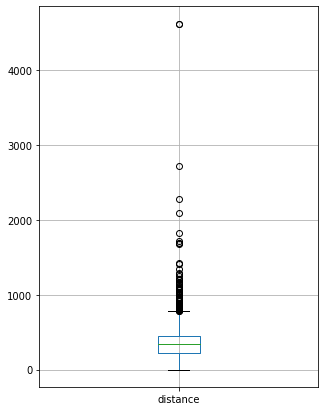

In [14]:
print(df_stop_distance_merged[['LineId', 'Type', 'Direction', 'distance', 'FromStop', 'ToStop']].nlargest(5, 'distance'))
print(df_stop_distance_merged[['distance']].describe())
print(df_stop_distance_merged[['distance']].boxplot(figsize=(5,7)))

## Data Analysis

After viewing a box plot of distance, there are some obvious outliers that may need to be dropped or cleaned later on. Below, we explore the data's distribution after filtering out 1.5 * IQR (inter-quartile range) which is a typical measure of outlier. We will also look to see how many values this would remove.

After reviewing the data along with the actual stops, it was seen that the outliers are real data, as the longest distance between stops is on bus line 12 travelling to the airport, with a distance between stops in the 5 km range. This aligns well with the data, indicating there are no issues with our upper range date.

We can also see that there are 517 stop segments that have a distance of 0 km. This could be due to the distance between terminus stops at either end of a line, or potentially some other factor. We will see later on in the speed calculation how these distances resulted in a speed calculation of "0 km/h". For the first pass through the data to draw STIB network level conclusions, these values were not investigated and will be dropped latter on in the speed calculation. This would be a place to return to the data to do additional data exploration.

AxesSubplot(0.125,0.125;0.775x0.755)
Count of unfiltered distances is: 
 4511 

Count of filtered distances is: 
 4409 

Count of '0' distances is: 
 distance    517
dtype: int64 



,distance
count,3892.000000
mean,362.893774
std,139.212075
min,5.414795
25%,261.809106
50%,354.137831
75%,455.402780
max,781.344789


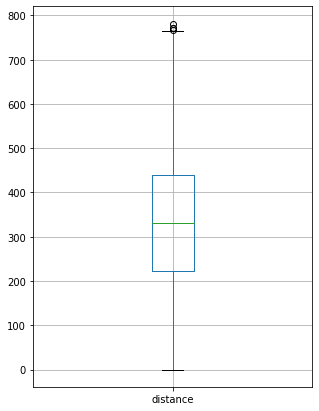

In [16]:
# Remove outliers from a dataframe by column, including optional whiskers, removing rows for which the column value are less than Q1-1.5IQR or greater than Q3+1.5IQR.
def subset_by_iqr(df: pd.DataFrame, column: str, whisker_width=1.5) -> pd.DataFrame:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]

df_filtered = subset_by_iqr(df_stop_distance_merged, 'distance', whisker_width=1.5)
print(df_filtered[['distance']].boxplot(figsize=(5,7)))
print("Count of unfiltered distances is: \n", df_stop_distance_merged[['distance']].count().sum(), "\n")
print("Count of filtered distances is: \n", df_filtered[['distance']].count().sum(), "\n")
print(f"Count of '0' distances is: \n", df_filtered[['distance']].isin([0]).sum(), "\n")

df_filtered = df_filtered.loc[df_filtered['distance'] > 0]
df_filtered[['distance']].describe()

In [150]:
# finally, we export the distance to a csv file named stop_distance.csv
df_stop_distance_merged.to_csv(r'../data/processed/assignment1/stop_distance.csv', index=False, header=True)

## Calculate Speed

We now have the time and distance between stops that we need to calculate speed. Here we will merge the `stop_distance.csv` and `average_time_between_stops_filtered.csv` tables with a division to create a table of average hourly speeds between every stop segment on every line.

Some speeds resulted in a value of "inf" (distance/0 = infinity). This warrants some additional investigation for future iterations if a greater resolution of data is needed. For now, we will drop any speeds that are showing as "inf" and take a peek at how the speed data for line 72 varies over time with a series of hourly boxplots. We would hypothesize that the vehicle speed would decrease during morning and afternoon rush hour.

In [36]:
stop_distance_path = '../data/processed/assignment1/stop_distance.csv'
stop_time_path = '../data/processed/assignment1/average_time_between_stops_filtered.csv'

# initialize a dictionary that will be used to make a dataframe and csv file
stop_time = pd.read_csv(stop_time_path)
stop_distance = pd.read_csv(stop_distance_path)
stop_distance['FromStop'].astype('float_', copy=True, errors='raise')
stop_distance['ToStop'].astype('float_', copy=True, errors='raise')

def calculate_speed(time: pd.DataFrame, distance: pd.DataFrame) -> pd.DataFrame:
    merged_time_distance = time.merge(distance, how='left', on=['LineId', 'FromStop', 'ToStop'])
    for hour in range(0, 24):
        merged_time_distance[f"speed{hour}"] = (merged_time_distance['distance'] / merged_time_distance[
            f"{hour}"]) * 3.6
    merged_time_distance.drop(columns=['distance', *[f'{i}' for i in range(24)]], inplace=True)
    return merged_time_distance

df_speed = calculate_speed(stop_time, stop_distance)

          speed7     speed8     speed9    speed10    speed11    speed12  \
count  16.000000  25.000000  25.000000  25.000000  25.000000  25.000000   
mean   16.906765  14.934410  17.439004  16.738013  15.589888  17.345880   
std     7.612827   6.605189   6.499785   6.404245   5.363655   6.471373   
min     2.710827   2.945260   2.995581   3.021969   3.103848   3.201245   
25%    14.489430  10.172396  14.154441  14.008978  13.926953  13.322901   
50%    19.041073  14.905394  17.725066  18.189287  16.703723  17.727997   
75%    20.989779  18.400792  20.832077  21.667680  19.688451  21.252134   
max    30.112057  27.452810  28.834675  29.156778  22.368208  30.690894   

         speed13    speed14    speed15    speed16    speed17    speed18  \
count  25.000000  25.000000  25.000000  25.000000  25.000000  25.000000   
mean   17.315772  16.263069  15.653817  15.334685  14.899769  16.851614   
std     6.471386   5.776993   4.908359   5.635238   5.987488   6.930831   
min     3.020178   3.120

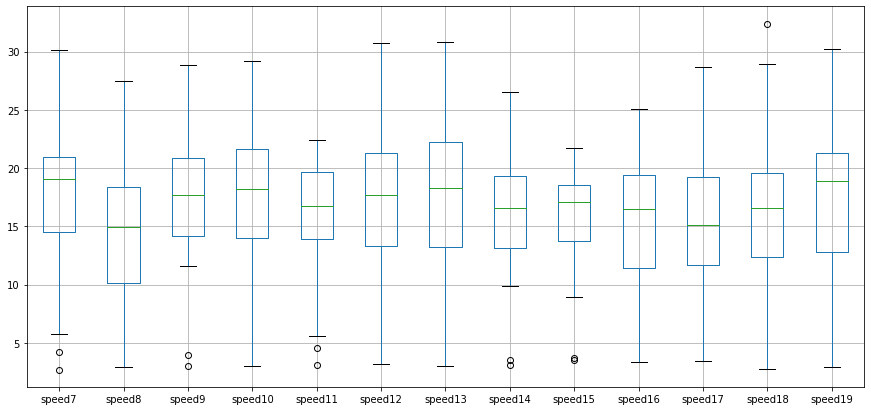

In [56]:
df_speed.replace([np.inf, -np.inf], np.nan, inplace=True)
df_speed.dropna(subset=["speed9"], how="all", inplace=True)

df_speed_speed_hour = df_speed[['LineId', 'speed7', 'speed8', 'speed9', 'speed10', 'speed11','speed12','speed13','speed14','speed15','speed16', 'speed17','speed18','speed19']]
df_speed_speed_hour_72 = df_speed_speed_hour[df_speed_speed_hour['LineId']==72]
df_speed_speed_hour_72 = df_speed_speed_hour_72[['speed7', 'speed8', 'speed9', 'speed10', 'speed11','speed12','speed13','speed14','speed15','speed16', 'speed17','speed18','speed19']]

print(df_speed_speed_hour_72.describe())
print(df_speed_speed_hour_72.boxplot(figsize=(15,7)))

In [18]:
df_speed.to_csv(r'../data/processed/assignment1/vehicleSpeed.csv', index=False, header=True)

We can see in the above data that the speed makes sense.
> #### This data is sufficiently clean to draw conclusions between major segments or line to line comparisons for general STIB network speed analysis.

We will input this data later on into Kepler.gl for visualization and to compare sub-segments or line to line performance. Most importantly, the data is setup in a way that will allow a user to easily filter through results to see query results immediately.

> #### Filtering with visualization is a powerful tool for decision makers to refine project scope and focus analysis to apply resources in the areas most important to the business.

If more in-depth analysis is desired, for example to look at the performance of a single critical line, it would be necessary to investigate the areas of 0 km/h speed, as well as to look at all the locatons where the speed was calculated as "inf".